# Flow Matching on Checkerbaord data

# Data Generation


In [3]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

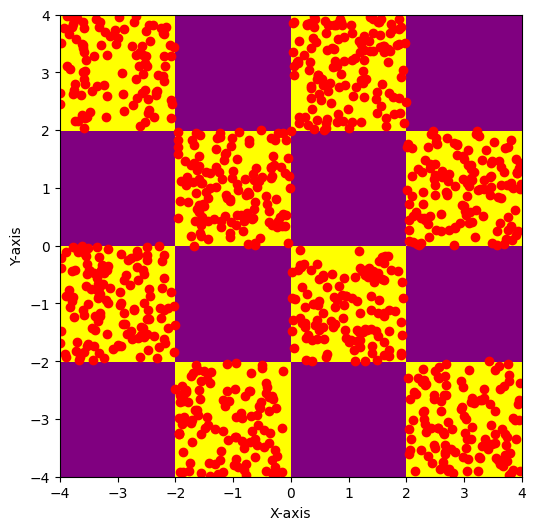

In [4]:
# parameters
N = 1000 # number of point to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4
resolution = 100 # resolution of the grid


# create the grid
x = np.linspace(x_min, x_max)
y = np.linspace(y_min, y_max)

X, Y = np.meshgrid(x, y)

# Checkerboard pattern
length = 4
checkerboard = np.indices((length, length)).sum(axis=0) % 2

# Sample points in regions where checkerboard pattern is 1
sampled_points = []
while len(sampled_points) < N:
    # Randomly sample a point within the x and y range
    x_sample = np.random.uniform(x_min, x_max)
    y_sample = np.random.uniform(y_min, y_max)
    
    # Determine the closest grid index
    i = int((x_sample - x_min) / (x_max - x_min) * length)
    j = int((y_sample - y_min) / (y_max - y_min) * length)
    
    # Check if the sampled point is in a region where checkerboard == 1
    if checkerboard[j, i] == 1:
        sampled_points.append((x_sample, y_sample))

# Convert to NumPy array for easier plotting
sampled_points = np.array(sampled_points)

# Plot the checkerboard pattern
plt.figure(figsize=(6, 6))
plt.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["purple", "yellow"]))

# Plot sampled points
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


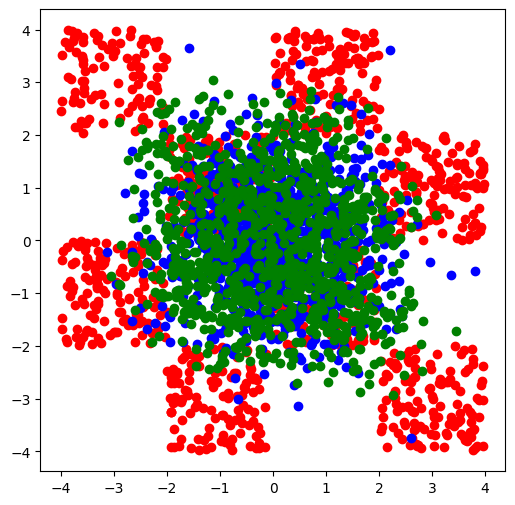

In [5]:
t = 0.5
noise = np.random.randn(N, 2)
plt.figure(figsize=(6, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.scatter(noise[:, 0], noise[:, 1], color="blue", marker="o")
plt.scatter((1 - t) * noise[:, 0] + t * sampled_points[:, 0], (1 - t) * noise[:, 1] + t * sampled_points[:, 1], color="green", marker="o")
plt.show()


# Why We Need Time Embedding (gen_t_embedding)
The core problem: The neural network needs to understand what time t it's operating at, because the velocity field should behave differently at different times:

At t=0: Should move away from noise distribution
At t=0.5: Should handle intermediate interpolated points
At t=1: Should refine near the target distribution

Simple scalar time won't work well because:

A single number (t ∈ [0,1]) doesn't provide rich enough representation
Neural networks struggle to learn complex time-dependent behaviors from just one scalar





In [77]:
import torch
import math
import numpy as np

def simple_time_embedding_example():
    """
    Simple example showing how time embedding works step by step
    """
    print("=== TIME EMBEDDING STEP BY STEP ===\n")
    
    # Example input
    t = torch.tensor([0.5])  # Single time value: halfway through flow
    channels_t = 4           # Small embedding size for clarity
    max_positions = 10000
    
    print(f"Input time t: {t.item()}")
    print(f"Embedding dimension: {channels_t}")
    
    # Step 1: Scale time
    t_scaled = t * max_positions
    print(f"\nStep 1 - Scale time: {t.item()} * {max_positions} = {t_scaled.item()}")
    
    # Step 2: Calculate half dimension
    half_dim = channels_t // 2  # 4 // 2 = 2
    print(f"\nStep 2 - Half dimension: {half_dim}")
    
    # Step 3: Create frequency base
    emb_base = math.log(max_positions) / (half_dim - 1)
    print(f"\nStep 3 - Frequency base: log({max_positions}) / ({half_dim} - 1) = {emb_base:.4f}")
    
    # Step 4: Create exponential frequencies
    frequencies = torch.arange(half_dim).float() * (-emb_base)
    frequencies = torch.exp(frequencies)
    print(f"\nStep 4 - Frequencies: {frequencies}")
    print(f"  These are different 'speeds' of oscillation")
    
    # Step 5: Multiply time by frequencies
    time_freq = t_scaled[:, None] * frequencies[None, :]  # Broadcasting
    print(f"\nStep 5 - Time × Frequencies:")
    print(f"  Shape: {time_freq.shape}")
    print(f"  Values: {time_freq}")
    
    # Step 6: Apply sine and cosine
    sin_emb = torch.sin(time_freq)
    cos_emb = torch.cos(time_freq)
    print(f"\nStep 6 - Apply sin/cos:")
    print(f"  Sin values: {sin_emb}")
    print(f"  Cos values: {cos_emb}")
    
    # Step 7: Concatenate
    final_embedding = torch.cat([sin_emb, cos_emb], dim=1)
    print(f"\nStep 7 - Final embedding:")
    print(f"  Shape: {final_embedding.shape}")
    print(f"  Values: {final_embedding}")
    
    return final_embedding

def compare_different_times():
    """
    Show how different times create different embeddings
    """
    print("\n\n=== COMPARING DIFFERENT TIMES ===\n")
    
    def get_embedding(t_val, channels_t=4, max_positions=10000):
        t = torch.tensor([t_val])
        t_scaled = t * max_positions
        half_dim = channels_t // 2
        emb_base = math.log(max_positions) / (half_dim - 1)
        frequencies = torch.exp(torch.arange(half_dim).float() * (-emb_base))
        time_freq = t_scaled[:, None] * frequencies[None, :]
        sin_emb = torch.sin(time_freq)
        cos_emb = torch.cos(time_freq)
        return torch.cat([sin_emb, cos_emb], dim=1)
    
    times = [0.0, 0.25, 0.5, 0.75, 1.0]
    
    for t_val in times:
        emb = get_embedding(t_val)
        print(f"t = {t_val:4.2f} -> embedding: {emb.squeeze().numpy()}")
    
    print("\nNotice: Each time gets a UNIQUE embedding pattern!")

def demonstrate_forward_pass():
    """
    Show how time embedding is used in the forward pass
    """
    print("\n\n=== FORWARD PASS EXAMPLE ===\n")
    
    # Simulate the forward pass
    batch_size = 2
    x_input = torch.tensor([[1.5, -0.8], [0.2, 2.1]])  # 2D spatial data
    t_input = torch.tensor([0.3, 0.7])  # Different times for each sample
    
    print(f"Input spatial data x: {x_input}")
    print(f"Input times t: {t_input}")
    
    # Step 1: Project spatial data to higher dimension
    channels = 4  # Hidden dimension
    in_projection = torch.nn.Linear(2, channels, bias=False)
    # Set weights manually for demonstration
    with torch.no_grad():
        in_projection.weight = torch.nn.Parameter(torch.eye(4, 2))
    
    x_projected = in_projection(x_input)
    print(f"\nSpatial data projected to {channels}D: {x_projected}")
    
    # Step 2: Generate time embeddings
    def get_time_embedding(t, channels_t=4):
        max_positions = 10000
        t_scaled = t * max_positions
        half_dim = channels_t // 2
        emb_base = math.log(max_positions) / (half_dim - 1)
        frequencies = torch.exp(torch.arange(half_dim).float() * (-emb_base))
        time_freq = t_scaled[:, None] * frequencies[None, :]
        sin_emb = torch.sin(time_freq)
        cos_emb = torch.cos(time_freq)
        return torch.cat([sin_emb, cos_emb], dim=1)
    
    t_embedded = get_time_embedding(t_input, channels)
    print(f"\nTime embeddings: {t_embedded}")
    
    # Step 3: Project time embeddings
    t_projection = torch.nn.Linear(channels, channels, bias=False)
    with torch.no_grad():
        t_projection.weight = torch.nn.Parameter(torch.eye(channels))
    
    t_projected = t_projection(t_embedded)
    print(f"\nTime embeddings projected: {t_projected}")
    
    # Step 4: Add spatial and time information
    combined = x_projected + t_projected
    print(f"\nCombined (x + t): {combined}")
    
    print(f"\nKey insight: Each sample gets DIFFERENT combined features")
    print(f"because they have different times!")

if __name__ == "__main__":
    # Run all examples
    simple_time_embedding_example()
    compare_different_times()
    demonstrate_forward_pass()


=== TIME EMBEDDING STEP BY STEP ===

Input time t: 0.5
Embedding dimension: 4

Step 1 - Scale time: 0.5 * 10000 = 5000.0

Step 2 - Half dimension: 2

Step 3 - Frequency base: log(10000) / (2 - 1) = 9.2103

Step 4 - Frequencies: tensor([1.0000e+00, 1.0000e-04])
  These are different 'speeds' of oscillation

Step 5 - Time × Frequencies:
  Shape: torch.Size([1, 2])
  Values: tensor([[5.0000e+03, 5.0000e-01]])

Step 6 - Apply sin/cos:
  Sin values: tensor([[-0.9880,  0.4794]])
  Cos values: tensor([[0.1547, 0.8776]])

Step 7 - Final embedding:
  Shape: torch.Size([1, 4])
  Values: tensor([[-0.9880,  0.4794,  0.1547,  0.8776]])


=== COMPARING DIFFERENT TIMES ===

t = 0.00 -> embedding: [0. 0. 1. 1.]
t = 0.25 -> embedding: [-0.65012753  0.24740393  0.7598251   0.9689124 ]
t = 0.50 -> embedding: [-0.9879664  0.4794255  0.1546684  0.8775826]
t = 0.75 -> embedding: [-0.8512359   0.6816387  -0.52478325  0.7316889 ]
t = 1.00 -> embedding: [-0.30561438  0.8414709  -0.95215535  0.5403024 ]

Notice

# Flow Matching Model

In [7]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels) # Projects 2D data to 512D
        self.t_projection = nn.Linear(channels_t, channels) # Projects time embedding to 512D
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers) # 5 layers
        ])
        self.out_projection = nn.Linear(channels, channels_data) # Projects back to 2D
    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions # Scale t from [0,1] to [0,10000]
        half_dim = self.channels_t // 2 # 512 // 2 = 256
        emb = math.log(max_positions) / (half_dim - 1) # Base for exponential decay
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp() # [256] exponential frequencies
        emb = t[:, None] * emb[None, :]  # Broadcast: [batch] × [256] = [batch, 256]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1) # [batch, 512] - sine and cosine
        if self.channels_t % 2 == 1:  # zero ,   # Handle odd dimensions
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x) # [batch, 2] → [batch, 512]
        t = self.gen_t_embedding(t) # [batch] → [batch, 512] (rich time representation)
        t = self.t_projection(t) # [batch, 512] → [batch, 512] (learned projection)
        x = x + t # ADD time info to spatial data
        x = self.blocks(x)   # Process through network layers
        x = self.out_projection(x) # [batch, 512] → [batch, 2] (velocity output)
        return x

In [26]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
# Check for MPS availability on macOS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# Training loop

In [48]:
def training_loop_with_monitoring():
    """
    FULL TRAINING LOOP WITH PROGRESS MONITORING
    """
    print("\n\n=== FULL TRAINING LOOP ===\n")
    
    # Generate sample checkerboard data (simplified)
    np.random.seed(42)
    N = 1000
    sampled_points = []
    while len(sampled_points) < N:
        x_sample = np.random.uniform(-4, 4)
        y_sample = np.random.uniform(-4, 4)
        # Simple checkerboard logic
        i = int((x_sample + 4) / 2) % 2
        j = int((y_sample + 4) / 2) % 2
        if (i + j) % 2 == 1:
            sampled_points.append([x_sample, y_sample])
    
    data = torch.tensor(sampled_points, dtype=torch.float32).to(device)
    
    # Model setup
    model = MLP(layers=5, channels=512).to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    # Training parameters
    training_steps = 100000  # Reduced for demo
    batch_size = 64
    losses = []
    
    print(f"Training on {device}")
    print(f"Data shape: {data.shape}")
    print(f"Training steps: {training_steps}")
    
    # Training loop with progress bar
    pbar = tqdm(range(training_steps), desc="Training")
    
    for step in pbar:
        # Sample batch
        x1 = data[torch.randint(data.size(0), (batch_size,))]
        x0 = torch.randn_like(x1)
        
        # Calculate target velocity
        target = x1 - x0
        
        # Sample time
        t = torch.rand(x1.size(0)).to(device)
        
        # Interpolate
        xt = (1 - t[:, None]) * x0 + t[:, None] * x1
        
        # Model prediction
        pred = model(xt, t)
        
        # Loss
        loss = ((target - pred)**2).mean()
        
        # Backpropagation
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        # Logging
        losses.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.6f}")
        
        # Print progress every 100 steps
        if step % 100 == 0:
            print(f"\nStep {step}: Loss = {loss.item():.6f}")
    
    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Training Loss Over Time")
    plt.xlabel("Training Step")
    plt.ylabel("MSE Loss")
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    
    print(f"\nTraining completed!")
    print(f"Final loss: {losses[-1]:.6f}")
    
    return model, losses



=== FULL TRAINING LOOP ===

Training on mps
Data shape: torch.Size([1000, 2])
Training steps: 100000


Training:   0%|          | 0/100000 [00:00<?, ?it/s]


Step 0: Loss = 6.441514

Step 100: Loss = 3.549867

Step 200: Loss = 4.933018

Step 300: Loss = 4.087899

Step 400: Loss = 3.858822

Step 500: Loss = 3.396024

Step 600: Loss = 3.060892

Step 700: Loss = 4.043244

Step 800: Loss = 3.758756

Step 900: Loss = 3.278549

Step 1000: Loss = 3.181104

Step 1100: Loss = 2.303344

Step 1200: Loss = 4.223403

Step 1300: Loss = 3.676644

Step 1400: Loss = 3.594639

Step 1500: Loss = 3.042799

Step 1600: Loss = 3.511980

Step 1700: Loss = 3.282546

Step 1800: Loss = 3.650168

Step 1900: Loss = 2.782298

Step 2000: Loss = 3.773665

Step 2100: Loss = 2.976184

Step 2200: Loss = 3.784367

Step 2300: Loss = 3.437015

Step 2400: Loss = 4.020017

Step 2500: Loss = 2.334343

Step 2600: Loss = 3.287212

Step 2700: Loss = 4.066721

Step 2800: Loss = 4.097119

Step 2900: Loss = 2.779610

Step 3000: Loss = 3.066563

Step 3100: Loss = 3.298583

Step 3200: Loss = 2.886399

Step 3300: Loss = 3.846371

Step 3400: Loss = 3.447302

Step 3500: Loss = 3.668060

Ste

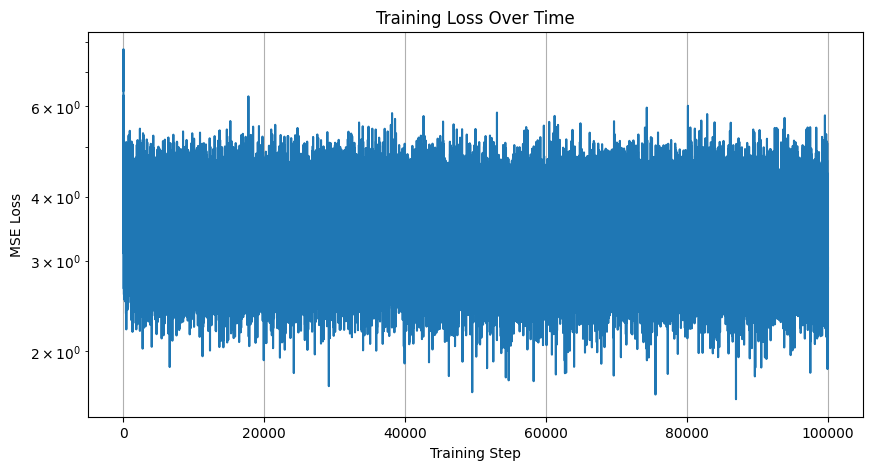


Training completed!
Final loss: 2.906680


In [49]:
model, losses = training_loop_with_monitoring()

# Sampling

In [54]:
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Make sure device is set
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def simple_sampling_with_colors(model, sampled_points):
    """
    Simple sampling with blue->orange colors and plotting
    """
    torch.manual_seed(42)
    model.eval().requires_grad_(False)
    
    xt = torch.randn(1000, 2).to(device)
    steps = 100000
    plot_every = 10000
    
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        t_expanded = t.expand(xt.size(0)).to(device)
        pred = model(xt, t_expanded)
        xt = xt + (1 / steps) * pred
        
        if i % plot_every == 0:
            plt.figure(figsize=(8, 6))
            # Orange for original data, blue for generated
            plt.scatter(sampled_points[:, 0], sampled_points[:, 1], 
                       color="orange", marker="o", alpha=0.7, label="Target Data")
            plt.scatter(xt.cpu()[:, 0], xt.cpu()[:, 1], 
                       color="blue", marker="o", alpha=0.7, label="Generated")
            plt.title(f"Step {i}/{steps} (t={t:.2f})")
            plt.legend()
            plt.xlim(-4, 4)
            plt.ylim(-4, 4)
            plt.grid(True, alpha=0.3)
            plt.show()
    
    model.train().requires_grad_(True)
    print("Done Sampling")
    return xt.cpu()


def quick_sampling_demo(model, sampled_points):
    """
    Quick demo with just a few snapshots
    """
    torch.manual_seed(42)
    model.eval().requires_grad_(False)
    
    xt = torch.randn(1000, 2).to(device)
    steps = 1000
    
    # Create subplots for snapshots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    snapshot_steps = [0, 200, 400, 600, 800, 1000]
    snapshot_idx = 0
    
    # Initial plot
    axes[0].scatter(sampled_points[:, 0], sampled_points[:, 1], 
                   color="orange", alpha=0.7, s=10, label="Target")
    axes[0].scatter(xt.cpu()[:, 0], xt.cpu()[:, 1], 
                   color="blue", alpha=0.7, s=10, label="Generated")
    axes[0].set_title("t=0.0 (Start)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(-4, 4)
    axes[0].set_ylim(-4, 4)
    
    # Run sampling
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        t_expanded = t.expand(xt.size(0)).to(device)
        pred = model(xt, t_expanded)
        xt = xt + (1 / steps) * pred
        
        # Save snapshots
        if i in snapshot_steps[1:]:
            snapshot_idx += 1
            axes[snapshot_idx].scatter(sampled_points[:, 0], sampled_points[:, 1], 
                                     color="orange", alpha=0.7, s=10, label="Target")
            axes[snapshot_idx].scatter(xt.cpu()[:, 0], xt.cpu()[:, 1], 
                                     color="blue", alpha=0.7, s=10, label="Generated")
            axes[snapshot_idx].set_title(f"t={t:.1f}")
            axes[snapshot_idx].legend()
            axes[snapshot_idx].grid(True, alpha=0.3)
            axes[snapshot_idx].set_xlim(-4, 4)
            axes[snapshot_idx].set_ylim(-4, 4)
    
    plt.tight_layout()
    plt.suptitle("Flow Matching Sampling Process", y=1.02)
    plt.show()
    
    model.train().requires_grad_(True)
    return xt.cpu()

# Usage examples:
print("Usage:")
print("1. Simple sampling with colors:")
print("   samples = simple_sampling_with_colors(model, sampled_points)")
print()
print("2. Animated sampling:")
print("   anim = animate_sampling(model, sampled_points)")
print()
print("3. Quick snapshots:")
print("   samples = quick_sampling_demo(model, sampled_points)")

Usage:
1. Simple sampling with colors:
   samples = simple_sampling_with_colors(model, sampled_points)

2. Animated sampling:
   anim = animate_sampling(model, sampled_points)

3. Quick snapshots:
   samples = quick_sampling_demo(model, sampled_points)


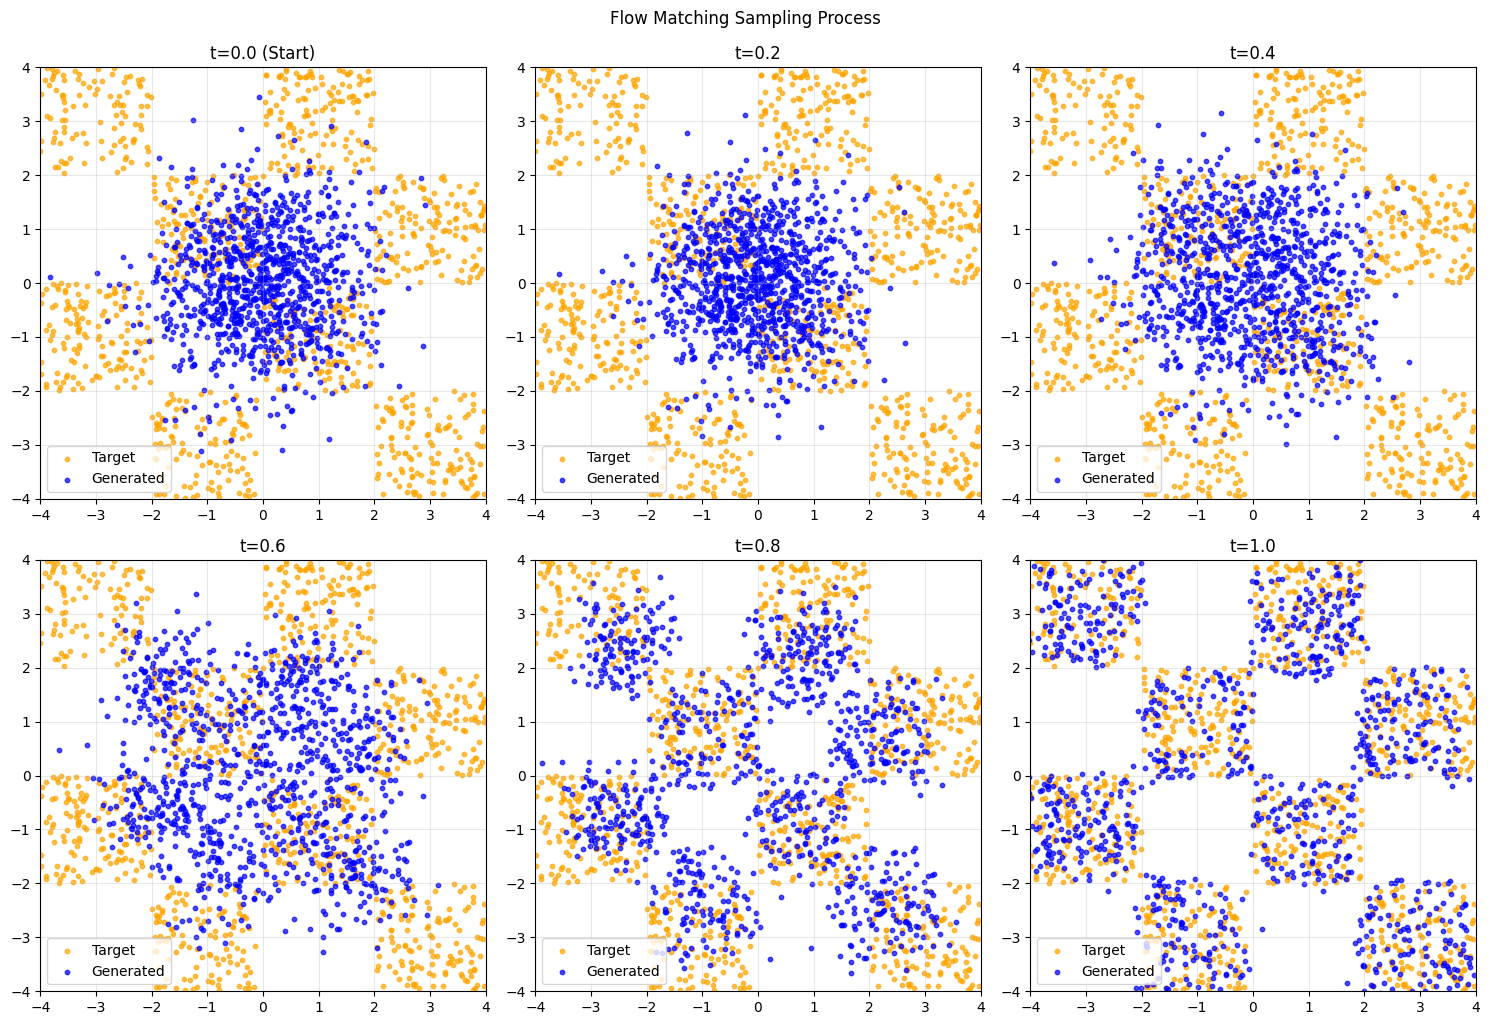

In [76]:
# Use the quick_sampling_demo function:
samples = quick_sampling_demo(model, sampled_points)

# Animation for Sampling


In [56]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

def simple_live_animation(model, sampled_points):
    """
    Simple live animation that works in Jupyter
    """
    print("Starting live animation...")
    
    torch.manual_seed(42)
    model.eval().requires_grad_(False)
    
    xt = torch.randn(1000, 2).to(device)
    steps = 1000
    show_every = 100  # Show frame every 100 steps
    
    # Set up the plot
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        t_expanded = t.expand(xt.size(0)).to(device)
        pred = model(xt, t_expanded)
        xt = xt + (1 / steps) * pred
        
        if i % show_every == 0:
            # Clear and update plot
            ax.clear()
            
            # Plot points
            ax.scatter(sampled_points[:, 0], sampled_points[:, 1], 
                      color="orange", alpha=0.7, s=10, label="Target")
            ax.scatter(xt.cpu()[:, 0], xt.cpu()[:, 1], 
                      color="blue", alpha=0.7, s=10, label="Generated")
            
            # Set plot properties
            ax.set_xlim(-4, 4)
            ax.set_ylim(-4, 4)
            ax.set_title(f"Flow Matching Animation - Step {i}/{steps} (t={t:.2f})")
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Update display
            plt.draw()
            plt.pause(0.1)  # Small pause to see the animation
    
    plt.ioff()  # Turn off interactive mode
    model.train().requires_grad_(True)
    print("Animation complete!")
    return xt.cpu()

def frame_by_frame_animation(model, sampled_points):
    """
    Alternative: Show frames one by one with manual control
    """
    torch.manual_seed(42)
    model.eval().requires_grad_(False)
    
    xt = torch.randn(1000, 2).to(device)
    steps = 1000
    save_every = 200  # Save every 200 steps
    
    frames = []
    time_points = []
    
    # Collect frames
    frames.append(xt.cpu().numpy().copy())
    time_points.append(0.0)
    
    print("Generating frames...")
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        t_expanded = t.expand(xt.size(0)).to(device)
        pred = model(xt, t_expanded)
        xt = xt + (1 / steps) * pred
        
        if i % save_every == 0:
            frames.append(xt.cpu().numpy().copy())
            time_points.append(t.item())
    
    model.train().requires_grad_(True)
    
    # Show frames one by one
    print(f"Created {len(frames)} frames. Showing them:")
    
    for i, (frame_points, t_val) in enumerate(zip(frames, time_points)):
        clear_output(wait=True)  # Clear previous output
        
        plt.figure(figsize=(8, 6))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], 
                   color="orange", alpha=0.7, s=10, label="Target")
        plt.scatter(frame_points[:, 0], frame_points[:, 1], 
                   color="blue", alpha=0.7, s=10, label="Generated")
        
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.title(f"Frame {i+1}/{len(frames)} - t={t_val:.2f}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        time.sleep(0.5)  # Wait half a second between frames
    
    print("Animation complete!")
    return frames[-1]  # Return final frame

def static_grid_animation(model, sampled_points):
    """
    Show all frames in a grid (no animation, but shows progression)
    """
    torch.manual_seed(42)
    model.eval().requires_grad_(False)
    
    xt = torch.randn(1000, 2).to(device)
    steps = 1000
    
    # Create grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    frame_steps = [0, 125, 250, 375, 500, 625, 750, 1000]
    frame_idx = 0
    
    # First frame (initial)
    axes[0].scatter(sampled_points[:, 0], sampled_points[:, 1], 
                   color="orange", alpha=0.7, s=8, label="Target")
    axes[0].scatter(xt.cpu()[:, 0], xt.cpu()[:, 1], 
                   color="blue", alpha=0.7, s=8, label="Generated")
    axes[0].set_title("t=0.0")
    axes[0].legend(fontsize=8)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(-4, 4)
    axes[0].set_ylim(-4, 4)
    
    # Run sampling and save frames
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        t_expanded = t.expand(xt.size(0)).to(device)
        pred = model(xt, t_expanded)
        xt = xt + (1 / steps) * pred
        
        if i in frame_steps[1:]:
            frame_idx += 1
            axes[frame_idx].scatter(sampled_points[:, 0], sampled_points[:, 1], 
                                   color="orange", alpha=0.7, s=8, label="Target")
            axes[frame_idx].scatter(xt.cpu()[:, 0], xt.cpu()[:, 1], 
                                   color="blue", alpha=0.7, s=8, label="Generated")
            axes[frame_idx].set_title(f"t={t:.2f}")
            axes[frame_idx].legend(fontsize=8)
            axes[frame_idx].grid(True, alpha=0.3)
            axes[frame_idx].set_xlim(-4, 4)
            axes[frame_idx].set_ylim(-4, 4)
    
    plt.tight_layout()
    plt.suptitle("Flow Matching Sampling Progression", y=1.02, fontsize=14)
    plt.show()
    
    model.train().requires_grad_(True)
    return xt.cpu()

# Usage:
print("Three animation options:")
print("1. Live animation (works best):")
print("   samples = simple_live_animation(model, sampled_points)")
print()
print("2. Frame by frame:")
print("   samples = frame_by_frame_animation(model, sampled_points)")
print()
print("3. Static grid (no animation, but shows progression):")
print("   samples = static_grid_animation(model, sampled_points)")

Three animation options:
1. Live animation (works best):
   samples = simple_live_animation(model, sampled_points)

2. Frame by frame:
   samples = frame_by_frame_animation(model, sampled_points)

3. Static grid (no animation, but shows progression):
   samples = static_grid_animation(model, sampled_points)


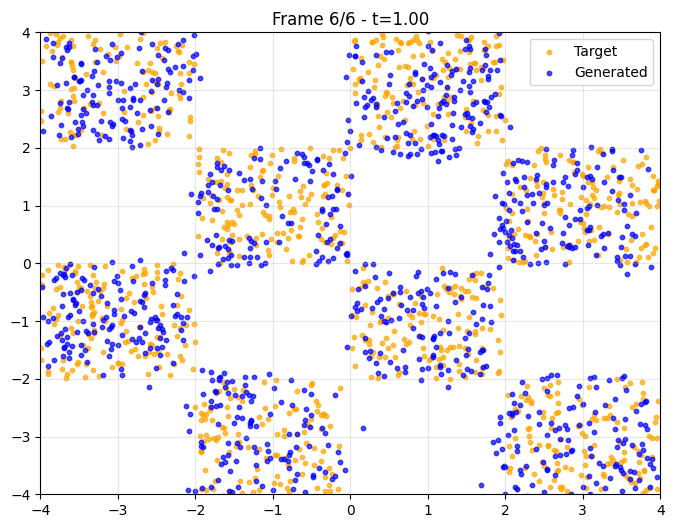

Animation complete!


In [78]:
samples = frame_by_frame_animation(model, sampled_points)

# Animate the Learned Vector Field


In [70]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

def visualize_vector_field_at_time(model, t_value, device, grid_size=20):
    """
    Visualize the vector field at a specific time t
    """
    model.eval()
    
    # Create a grid of points
    x = np.linspace(-4, 4, grid_size)
    y = np.linspace(-4, 4, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Flatten grid for model input
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), 
                              dtype=torch.float32).to(device)
    
    # Get time tensor
    t_tensor = torch.full((grid_points.shape[0],), t_value).to(device)
    
    # Get velocities from model
    with torch.no_grad():
        velocities = model(grid_points, t_tensor).cpu().numpy()
    
    # Reshape back to grid
    U = velocities[:, 0].reshape(X.shape)
    V = velocities[:, 1].reshape(X.shape)
    
    return X, Y, U, V

def animate_vector_field_simple(model, sampled_points, device):
    """
    Simple vector field animation using clear_output
    """
    print("Animating vector field over time...")
    
    time_points = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    for t_val in time_points:
        clear_output(wait=True)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Get vector field at this time
        X, Y, U, V = visualize_vector_field_at_time(model, t_val, device, grid_size=15)
        
        # Plot vector field (arrows)
        ax.quiver(X, Y, U, V, alpha=0.6, scale=50, width=0.003, color='gray')
        
        # Plot target data
        ax.scatter(sampled_points[:, 0], sampled_points[:, 1], 
                  color="orange", alpha=0.7, s=15, label="Target Data", zorder=5)
        
        # Styling
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_title(f"Vector Field at t={t_val:.1f}")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
        plt.show()
        time.sleep(0.8)  # Pause between frames
    
    print("Vector field animation complete!")


def simple_vector_field_demo(model, sampled_points, device):
    """
    Simple demo showing vector field at one time point
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Choose a time point (t=0.5 is usually interesting)
    t_val = 0.5
    X, Y, U, V = visualize_vector_field_at_time(model, t_val, device, grid_size=15)
    
    # Plot vector field
    ax.quiver(X, Y, U, V, alpha=0.7, scale=40, width=0.003, color='blue')
    
    # Plot target data
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], 
              color="orange", alpha=0.8, s=30, label="Target Data", zorder=5)
    
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_title(f"Learned Vector Field at t={t_val}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    plt.show()

# Usage examples:
print("Vector Field Visualization Options:")
print("1. Simple demo (one time point):")
print("   simple_vector_field_demo(model, sampled_points, device)")
print()
print("2. Simple animation (frame by frame):")
print("   animate_vector_field_simple(model, sampled_points, device)")
print()
print("3. Grid view (all times at once):")
print("   vector_field_grid(model, sampled_points, device)")

Vector Field Visualization Options:
1. Simple demo (one time point):
   simple_vector_field_demo(model, sampled_points, device)

2. Simple animation (frame by frame):
   animate_vector_field_simple(model, sampled_points, device)

3. Grid view (all times at once):
   vector_field_grid(model, sampled_points, device)


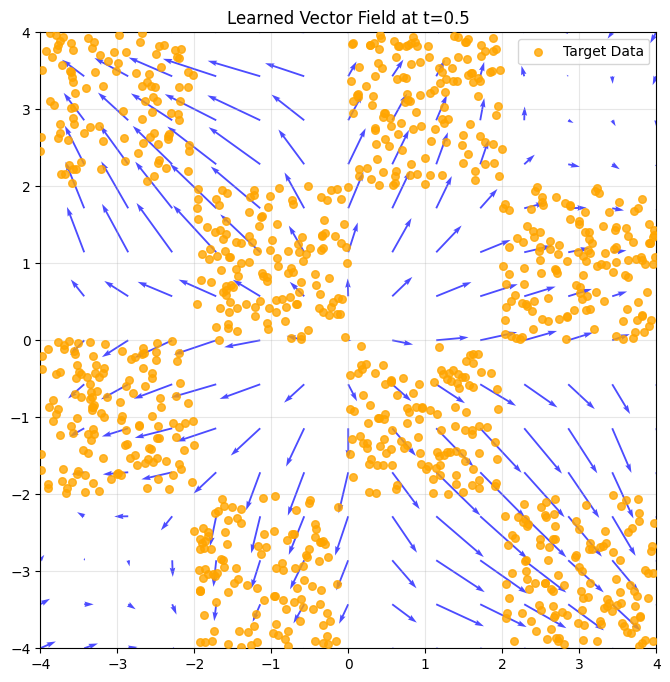

In [71]:
simple_vector_field_demo(model, sampled_points, device)

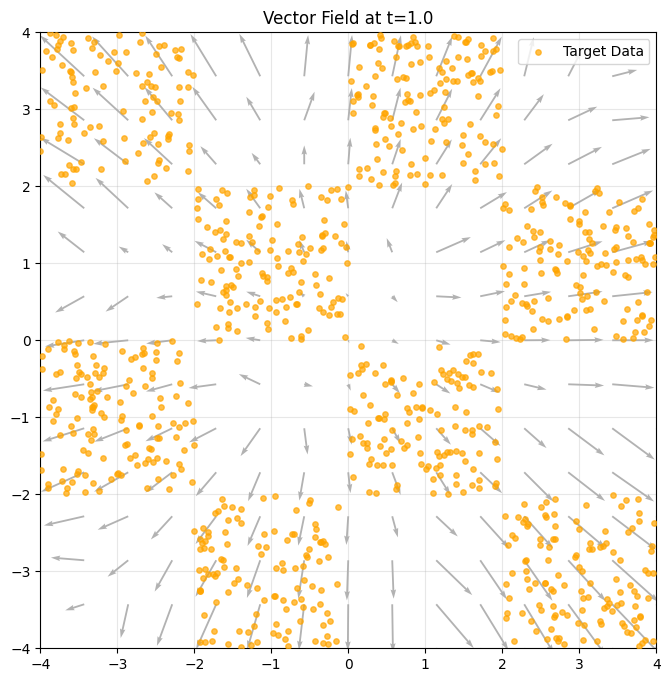

Vector field animation complete!


In [74]:
animate_vector_field_simple(model, sampled_points, device)